# Отток клиентов из банка

Увеличилось ежемесячное количество клиентов, ушедших из банка. Сохранить существующих клиентов дешевле, чем привлекать новых.

**Цели и задачи:**

Проанализировать исторические данные о поведении клиентов банка, расторжении договоров. Спрогнозировать уход клиента из банка.
Построить модель классификации, метрика качества f1 (минимальное значение 0.59)
Измерить AUC-ROC, сравнить её значение с f1-мерой.

**Источник данных:** https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling

**Признаки**

- RowNumber — индекс строки в данных
- CustomerId — уникальный идентификатор клиента
- Surname — фамилия
- CreditScore — кредитный рейтинг
- Geography — страна проживания
- Gender — пол
- Age — возраст
- Tenure — количество недвижимости у клиента
- Balance — баланс на счёте
- NumOfProducts — количество продуктов банка, используемых клиентом
- HasCrCard — наличие кредитной карты
- IsActiveMember — активность клиента
- stimatedSalary — предполагаемая зарплата

**Целевой признак**

- Exited — факт ухода клиента

# 1. Подготовка данных

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, r2_score
from sklearn.utils import shuffle

In [25]:
df = pd.read_csv('Churn.csv')
print(df.info())
df.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB
None


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
5,6,15574012,Chu,645,Spain,Male,44,8,113755.78,2,1,0,149756.71,1
6,7,15592531,Bartlett,822,France,Male,50,7,0.00,2,1,1,10062.80,0
7,8,15656148,Obinna,376,Germany,Female,29,4,115046.74,4,1,0,119346.88,1
8,9,15792365,He,501,France,Male,44,4,142051.07,2,0,1,74940.50,0
9,10,15592389,H?,684,France,Male,27,2,134603.88,1,1,1,71725.73,0


Присутствуют 909 пропусков в колонке Tenure, 3 колонки строкового формата

In [26]:
df.describe()

,RowNumber,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
count,10000.00000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,2886.89568,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.00000,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,2500.75000,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,5000.50000,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,7500.25000,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,10000.00000,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


In [27]:
df.nunique()

RowNumber          10000
CustomerId         10000
Surname             2932
CreditScore          460
Geography              3
Gender                 2
Age                   70
Tenure                11
Balance             6382
NumOfProducts          4
HasCrCard              2
IsActiveMember         2
EstimatedSalary     9999
Exited                 2
dtype: int64

Признаки RowNumber, CustomerId и Surname не несут в себе информации, необходимой для дальнейшей классификации. Удалим их.

In [28]:
df = df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

In [29]:
def show_hists(data, data_label, num_bins, rug=False, log_scale=False):
   
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(data_label + ". Плотность распределения", fontsize=18)
    axes[0].set_ylabel('плотность', fontsize=15)
    sns.distplot(data, bins=num_bins, rug=rug, ax=axes[0])
    axes[1].set_title(data_label + ". Boxplot", fontsize=18)
    sns.boxplot(data=df, x=data_label, ax=axes[1])
    plt.show()

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


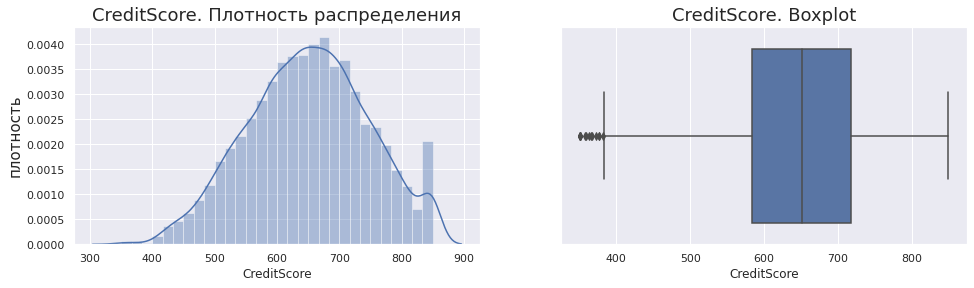

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


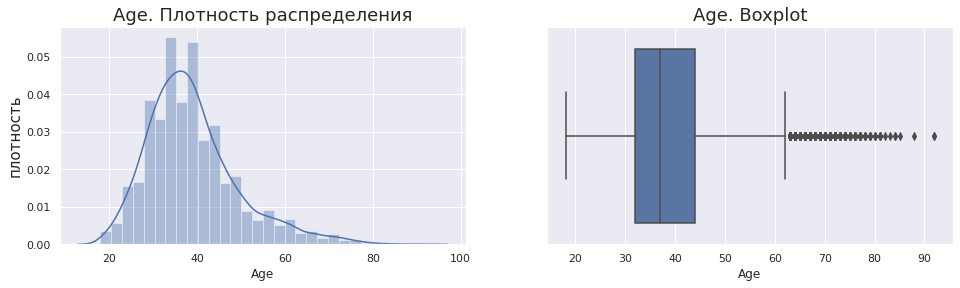

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


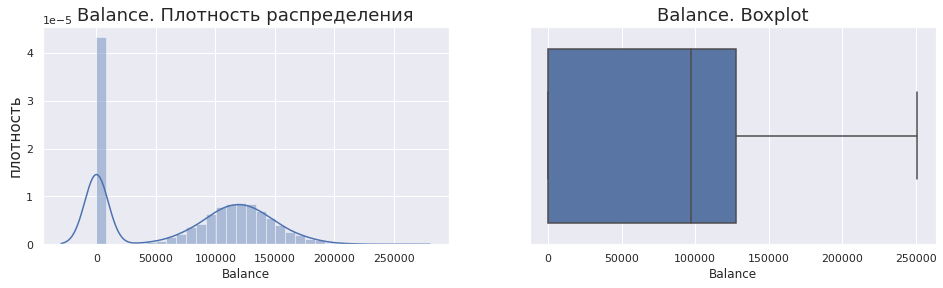

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


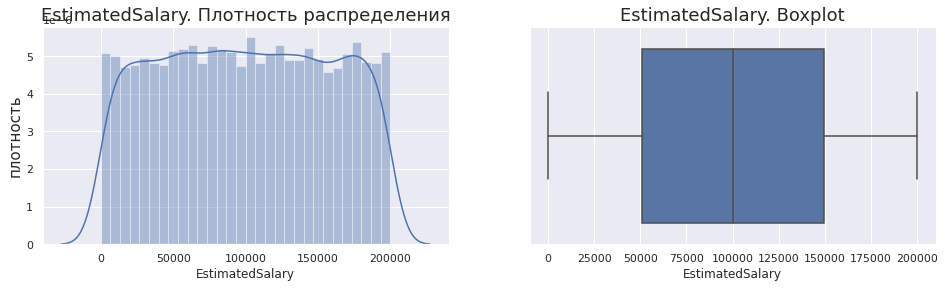

In [30]:
numerics = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
for column in numerics:
    show_hists(df[column], column, num_bins=30)

В признаках CreditScore, Age есть выбросы. Найдём их долю от общего количества данных.

In [31]:
# квантили считаем методом quantile()
# граница выбросов считается по формуле  [ q.75 + (q.75 - q.25)*1.5 ]
max_age = (df['Age'].quantile(0.75) - df['Age'].quantile(0.25))*1.5 + df['Age'].quantile(0.75)
rate = round(len(df.loc[df['Age'] > max_age]) / len(df) * 100, 2)
print('Доля выбросов в параметре {}: {} %'.format('Age', rate))

Доля выбросов в параметре Age: 3.59 %


In [32]:
# граница выбросов считается по формуле  [ q.25 - (q.75 - q.25)*1.5 ]
min_score = df['CreditScore'].quantile(0.25) - \
            (df['CreditScore'].quantile(0.75) - df['CreditScore'].quantile(0.25))*1.5
rate = round(len(df.loc[df['CreditScore'] < min_score]) / len(df) * 100, 2)
print('Доля выбросов в параметре {}: {} %'.format('CreditScore', rate))

Доля выбросов в параметре CreditScore: 0.15 %



Общая доля выбросов небольшая (меньше 4%). Не будем пока их удалять.


Чтобы не терять данные и не вносить дисбаланс, заполняю пропущенные значения колонки Tenure случайным числом, которое уже есть в этой колонке (от 0 до 10).

In [33]:
def random_digit(row):
    tenure = row['Tenure']
    if tenure >= 0:
        return tenure
    else:
        return random.randint(0,10)

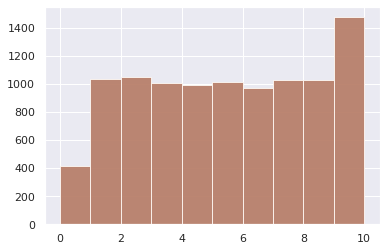

In [34]:
df['Tenure'].hist(alpha=0.8);
df['Tenure'] = df.apply(random_digit, axis=1)
df['Tenure'].hist(alpha=0.7);

К числовым признакам CreditScore, Age, Balance, EstimatedSalary применим масштабирование с помощью StandardScaler библиотеки sklearn

In [35]:
scaler = StandardScaler()
df[numerics] = scaler.fit_transform(df[numerics])

In [36]:
def show_hists(data, data_label1, data_label2=''):
   
    sns.set()
    f, axes = plt.subplots(1, 2, figsize=(16, 4))
    axes[0].set_title(data_label1 + ". CountPlot", fontsize=18)
    sns.countplot(data=df, x=data_label1, ax=axes[0])
    if data_label2 != '':
        axes[1].set_title(data_label2 + ". CountPlot", fontsize=18)
        sns.countplot(data=df, x=data_label2, ax=axes[1])
    plt.show()

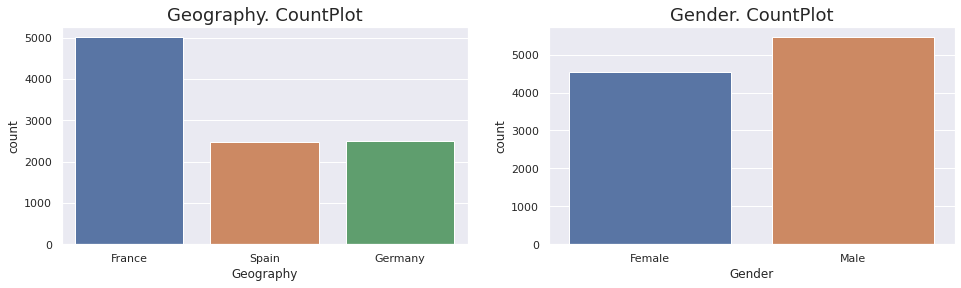

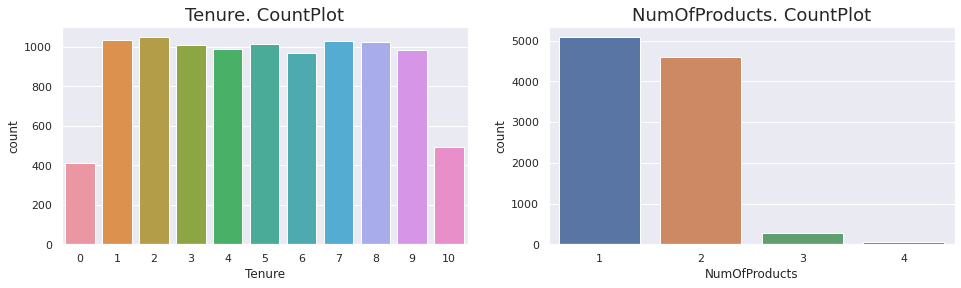

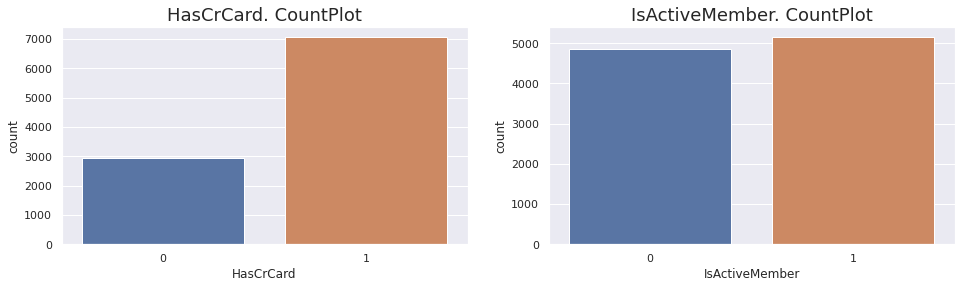

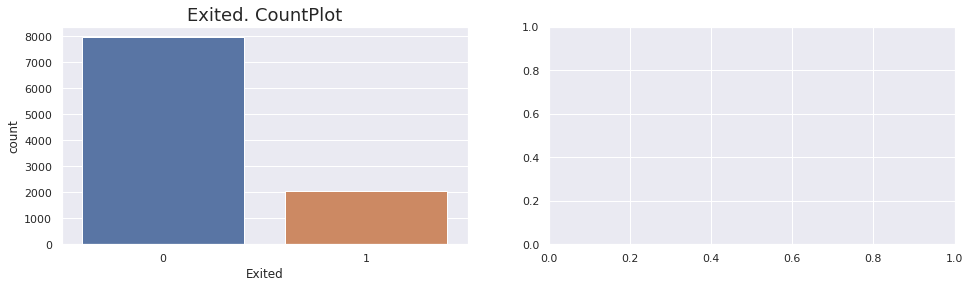

In [37]:
categoricals = ['Geography', 'Gender', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited', '']
for i in range(len(categoricals)//2):
    show_hists(df, categoricals[2*i], categoricals[2*i+1])

* Целевой признак Exited распределён примерно 4:1.
* Количество категорий в признаках Geography, Gender небольшое. Преобразуем их методом One-Hot Encoding.

In [38]:
# для преобразования воспользуемся методом pd.get_dummies
# параметр drop_first=True для удаления избыточного столбца данных
df = pd.get_dummies(df, drop_first=True)

Преобразуем типы данных признаков NumOfProducts, HasCrCard, IsActiveMember, Exited в int8 для экономии места.

In [39]:
for column in ['NumOfProducts', 'HasCrCard', 'IsActiveMember', 'Exited']:
    df[column] = df[column].astype('int8')

##Выводы

* Данные успешно загружены и проверены на соответствие описанию. Дубликатов нет. Типы данных преобразованы в соответствии с хранимой информацией
* Признаки RowNumber, CustomerId и Surname удалены, так как целевой признак от них никак не зависит.
* Были рассмотрены распределения признаков. В CreditScore, Age найдено около 4% выбросов. Пока оставлены как есть.
* Числовые признаки приведены к стандартному виду (среднее = 0, стандартное отклонение = 1)
* Категориальные признаки преобразованы методом One-Hot Encoder.
* Целевой признак распределён в сооотношении 4:1
* В признаке Tenure обнаружено около 10% пропусков. Чтобы не терять данные и не вносить дисбаланс, заполняю пропущенные значения колонки Tenure случайным числом, которое уже есть в этой колонке (от 0 до 10).

In [40]:
df.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,-0.326221,0.293517,2,-1.225848,1,1,1,0.021886,1,0,0,0
1,-0.440036,0.198164,1,0.117350,1,0,1,0.216534,0,0,1,0
2,-1.536794,0.293517,8,1.333053,3,1,0,0.240687,1,0,0,0
3,0.501521,0.007457,1,-1.225848,2,0,0,-0.108918,0,0,0,0
4,2.063884,0.388871,2,0.785728,1,1,1,-0.365276,0,0,1,0


# 2. Исследование задачи

In [41]:
 # Разделим данные
 features = df.drop('Exited', axis=1)
 target = df['Exited']

In [42]:
# Разделим данные на обучающую, валидационную и тестовую выборки в пропорции 3:1:1 соответственно (60% на обучающию и по 20% данных на валидационную и тестовую выборки).
X, X_test, y, y_test = train_test_split(features, target, test_size=0.2, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=123)

In [43]:
# выведем размеры получившихся выборок
print('Размеры наборов данных:')
print('X_train: ', X_train.shape)
print('X_valid: ', X_valid.shape)
print('X_test:  ', X_test.shape)

Размеры наборов данных:
X_train:  (6000, 11)
X_valid:  (2000, 11)
X_test:   (2000, 11)


Попробуем обучить различные классификационные модели без учёта дисбаланса классов.

## 2.1 Решающее дерево
**Инициируем модель решающего дерева DecisionTreeClassifier**

Выделим гиперпараметры для настройки модели:
* max_depth - максимальная глубина древа
* min_samples_split - минимальное количество объектов в узле
* min_samples_leaf - минимальное количество объектов в листе
* criterion ("gini" или "entropy") - функция измерения качества разделения
* Критерием проверки качества модели будет f1 и roc_auc.

In [44]:
def decision_tree(X_train, X_valid, y_train, y_valid, cw=None):
    """
    input: X_train, X_valid, y_train, y_valid - обучающие и валидационные выборки признаков и целевого признака
            cw - параметр class_weight для модели решающего дерева
    output: None
    description: функция обучает модель решающего дерева DecisionTreeClassifier с различными сочетаниями гиперпараметров;
                 метрики качества модели: f1 и roc_auc;
                 функция выводит наилучшие значения метрик и значения гиперпараметров наилучшей модели.
    """
    # в параметрах best_params_f1 и best_f1 будем хранить наилучшие параметры для модели и наивысшую f1 метрику соответственно
    best_params_f1 = []
    best_f1 = 0
    # аналогично для roc_auc метрики.
    best_params_roc_auc = []
    best_roc_auc = 0.5
    # проходим в циклах по всем выбранным гиперпараметрам
    for max_depth in range(2,10):
        for min_samples_split in range(2,6):
            for min_samples_leaf in range(1,10):
                for criterion in ['gini', 'entropy']:
                    # инициация модели с текущими гиперпараметрами
                    model_dt_clf = DecisionTreeClassifier(random_state=123,
                                                          max_depth=max_depth,
                                                          min_samples_split=min_samples_split,
                                                          min_samples_leaf=min_samples_leaf,
                                                          criterion=criterion,
                                                          class_weight=cw)
                    # обучение модели на тренировочной выборке
                    model_dt_clf.fit(X_train, y_train)
                    # поиск предсказаний модели на валидационной выбоке
                    predictions = model_dt_clf.predict(X_valid)
                    # вычисление f1 модели методом f1_score
                    f1 = f1_score(y_valid, predictions)
                    # если текущее значение метрики f1 выше предыдущего лучшего значения, 
                    # сохраняем параметры модели и текущую метрику f1
                    if f1 > best_f1:
                        best_params_f1 = [max_depth, min_samples_split, min_samples_leaf, criterion]
                        best_f1 = f1
                    # аналогично для метрики roc_auc
                    roc_auc = roc_auc_score(y_valid, predictions)
                    if roc_auc > best_roc_auc:
                        best_params_roc_auc = [max_depth, min_samples_split, min_samples_leaf, criterion]
                        best_roc_auc = roc_auc
    
    # вывод наилучшей метрики f1 и параметров модели.
    print('''Наилучшая метрика f1: {}
    Парамтеры модели:
       max_depth = {}
       min_samples_split = {}
       min_samples_leaf = {}
       criterion = {} \n'''.format(round(best_f1, 3),
                                 best_params_f1[0],
                                 best_params_f1[1],
                                 best_params_f1[2],
                                 best_params_f1[3]
                                ))
    
    # вывод наилучшей метрики roc_auc и параметров модели.
    print('''Наилучшая метрика roc_auc: {}
    Парамтеры модели:
       max_depth = {}
       min_samples_split = {}
       min_samples_leaf = {}
       criterion = {} '''.format(round(best_roc_auc, 3),
                                 best_params_roc_auc[0],
                                 best_params_roc_auc[1],
                                 best_params_roc_auc[2],
                                 best_params_roc_auc[3]
                                ))

In [45]:
decision_tree(X_train, X_valid, y_train, y_valid)

Наилучшая метрика f1: 0.569
    Парамтеры модели:
       max_depth = 5
       min_samples_split = 2
       min_samples_leaf = 2
       criterion = gini 

Наилучшая метрика roc_auc: 0.71
    Парамтеры модели:
       max_depth = 5
       min_samples_split = 2
       min_samples_leaf = 2
       criterion = gini 


* Наилучшая метрика f1 для решающего дерева 0.57 (не достаточно по техническому заданию).
* Наилучший результат по метрикам f1 и roc_auc достигается при одинаковой настройке гиперпараметров.
* Попробуем улучшить результат на других моделях

## 2.2 Случайный лес
**Инициируем модель случайного леса RandomForestClassifier**

Выделим гиперпараметры для настройки модели:
* n_estimators - количество деревьев
* max_depth - максимальная глубина древа
* min_samples_split - минимальное количество объектов в узле
* min_samples_leaf - минимальное количество объектов в листе
* Критерием проверки качества модели будет f1 и roc_auc.

In [46]:
def random_forest(X_train, X_valid, y_train, y_valid, cw=None):
    """
    input: X_train, X_valid, y_train, y_valid - обучающие и валидационные выборки признаков и целевого признака
            cw - параметр class_weight для модели случайного леса
    output: None
    description: функция обучает модель решающего дерева RandomForestClassifier с различными сочетаниями гиперпараметров;
                 метрики качества модели: f1 и roc_auc;
                 функция выводит наилучшие значения метрик и значения гиперпараметров наилучшей модели.
    """
    # в параметрах best_params_f1 и best_f1 будем хранить наилучшие параметры для модели и наивысшую f1 метрику соответственно
    best_params_f1 = []
    best_f1 = 0
    # аналогично для roc_auc метрики.
    best_params_roc_auc = []
    best_roc_auc = 0.5
    # проходим в циклах по всем выбранным гиперпараметрам
    for n_estimators in range(30,40):
        for max_depth in range(10,17,2):
            for min_samples_split in range(2,5):
                for min_samples_leaf in range(1,4):
                    # инициация модели с текущими гиперпараметрами
                    model_rf_clf = RandomForestClassifier(random_state=123,
                                                          n_estimators=n_estimators,
                                                          max_depth=max_depth,
                                                          min_samples_split=min_samples_split,
                                                          min_samples_leaf=min_samples_leaf)
                    # обучение модели на тренировочной выборке
                    model_rf_clf.fit(X_train, y_train)
                    # поиск предсказаний модели на валидационной выбоке
                    predictions = model_rf_clf.predict(X_valid)

                    # вычисление f1 модели методом f1_score
                    f1 = f1_score(y_valid, predictions)
                    # если текущее значение метрики f1 выше предыдущего лучшего значения, 
                    # сохраняем параметры модели и текущую метрику f1
                    if f1 > best_f1:
                        best_params_f1 = [n_estimators, max_depth, min_samples_split, min_samples_leaf]
                        best_f1 = f1
                    # аналогично для метрики roc_auc
                    roc_auc = roc_auc_score(y_valid, predictions)
                    if roc_auc > best_roc_auc:
                        best_params_roc_auc = [n_estimators, max_depth, min_samples_split, min_samples_leaf]
                        best_roc_auc = roc_auc

    # вывод наилучшей метрики f1 и параметров модели.
    print('''Наилучшая метрика f1: {}
    Парамтеры модели:
       n_estimators = {}
       max_depth = {}
       min_samples_split = {}
       min_samples_leaf = {} \n'''.format(round(best_f1, 3),
                                 best_params_f1[0],
                                 best_params_f1[1],
                                 best_params_f1[2],
                                 best_params_f1[3]
                                ))

    # вывод наилучшей метрики roc_auc и параметров модели.
    print('''Наилучшая метрика roc_auc: {}
    Парамтеры модели:
       n_estimators = {}
       max_depth = {}
       min_samples_split = {}
       min_samples_leaf = {} '''.format(round(best_roc_auc, 3),
                                 best_params_roc_auc[0],
                                 best_params_roc_auc[1],
                                 best_params_roc_auc[2],
                                 best_params_roc_auc[3]
                                ))

In [47]:
random_forest(X_train, X_valid, y_train, y_valid)

Наилучшая метрика f1: 0.574
    Парамтеры модели:
       n_estimators = 30
       max_depth = 16
       min_samples_split = 3
       min_samples_leaf = 1 

Наилучшая метрика roc_auc: 0.709
    Парамтеры модели:
       n_estimators = 30
       max_depth = 16
       min_samples_split = 3
       min_samples_leaf = 1 


* Наилучшая метрика f1 для случайного леса 0.574 (не достаточно по техническому заданию).
* Наилучший результат по метрикам f1 и roc_auc достигается при одинаковой настройке гиперпараметров.
* Попробуем улучшить результат на других моделях.


## 2.3 Логистическая регрессия
**Инициируем модель логистической регрессии LogisticRegression**

Выделим гиперпараметры для настройки модели:
* С - инверсия силы регуляризации
* Критерием проверки качества модели будет f1 и roc_auc.

In [48]:
# в параметрах best_params_f1 и best_f1 будем хранить наилучшие параметры для модели и наивысшую f1 метрику соответственно
best_params_f1 = []
best_f1 = 0
# аналогично для roc_auc метрики.
best_params_roc_auc = []
best_roc_auc = 0.5

#cs = np.linspace(0.01, 100, 1000, endpoint=True)
cs = range(1, 100)
# проходим в циклах по всем выбранным гиперпараметрам
for C in cs:
    # инициация модели с текущими гиперпараметрами
    model_lr_clf = LogisticRegression(random_state=123,
                                      C=C,
                                      max_iter=1000)
    # обучение модели на тренировочной выборке
    model_lr_clf.fit(X_train, y_train)
    # поиск предсказаний модели на валидационной выбоке
    predictions = model_lr_clf.predict(X_valid)

    # вычисление f1 модели методом f1_score
    f1 = f1_score(y_valid, predictions)
    # если текущее значение метрики f1 выше предыдущего лучшего значения, 
    # сохраняем параметры модели и текущую метрику f1
    if f1 > best_f1:
        best_params_f1 = [C]
        best_f1 = f1
    # аналогично для метрики roc_auc
    roc_auc = roc_auc_score(y_valid, predictions)
    if roc_auc > best_roc_auc:
        best_params_roc_auc = [C]
        best_roc_auc = roc_auc

In [49]:
# вывод наилучшей метрики f1 и параметров модели.
print('''Наилучшая метрика f1: {}
Парамтеры модели:
   C = {} '''.format(round(best_f1, 3),
                             best_params_f1[0]
                            ))

Наилучшая метрика f1: 0.272
Парамтеры модели:
   C = 1 


In [50]:
# вывод наилучшей метрики roc_auc и параметров модели.
print('''Наилучшая метрика roc_auc: {}
Парамтеры модели:
   C = {} '''.format(round(best_roc_auc, 3),
                             best_params_roc_auc[0]
                            ))

Наилучшая метрика roc_auc: 0.572
Парамтеры модели:
   C = 1 


* Наилучшая метрика f1 для логистической регрессии 0.27 (хуже, чем на остальных моделях).
* Наилучший результат по метрикам f1 и roc_auc достигается при одинаковой настройке гиперпараметров.
* Попробуем улучшить результат, разобравшись с дисбалансом классов.

## Выводы
* Исходные данные разделены на обучающую, валидационную и тестовую выборки в соотношении 3:1:1 соответственно
* Обучены модели "Решающее Дерево", "Случайный лес", "Логистическая Регрессия" без учёта дисбаланса классов. Максимальное значение метрики f1 = 0.58 получено при обучении модели случайного леса. Качество модели не удовлетворяет условию технического задания.
* Качество моделей также оценено по метрике roc_auc. Максимальное значение метрики roc_auc = 0.71 достигнуто при обучении модели случайного леса.
* Метрики f1 и roc_auc достигли максимальных значений при одинаковых настройках гиперпараметров (но такой результат получается не всегда).

# 3. Борьба с дисбалансом
* Соотношение значений целевого признака 4:1 (для классов 0 и 1 соответственно)
* Для борьбы с дисбалансом классов попробуем:
взвешивание классов (class_weight='balanced')
* увеличение выборки положительного класса (копирование объектов)
* уменьшение выборки отрицательного класса (sampling)
* перемешивание объектов методом shuffle

## 3.1 Взвешивание классов

In [51]:
decision_tree(X_train, X_valid, y_train, y_valid, cw='balanced')

Наилучшая метрика f1: 0.568
    Парамтеры модели:
       max_depth = 8
       min_samples_split = 2
       min_samples_leaf = 7
       criterion = gini 

Наилучшая метрика roc_auc: 0.751
    Парамтеры модели:
       max_depth = 6
       min_samples_split = 2
       min_samples_leaf = 6
       criterion = gini 


* Взвешивание классов почти не дало прироста в метрике f1 на решающем дереве.
* Отметим, что в данном случае наилучшие значения метрик f1 и roc_auc достигаются при различных настройках гиперпараметров.
* Применим upsampling и downsampling. Проверим результаты на модели случайного леса (она дала наилучший результат при начальном исследовании)

## 3.2 Upsampling и downsampling
* Напишем функции для увеличения и уменьшения выборок.

In [52]:
def upsample(features, target, repeat):
    """
    input:        features - признаки 
                  target - целево признак
                  repeat (int) - множитель для повторения признаков
    output:       features_upsampled - увеличенная выборка признаков
                  target_upsampled - увеличенная выборка целевого признака
    description:  функция разделяет признаки по классам целевого признака (0, 1),
                  повторяет признаки целевого положительного класса repeat раз,
                  объединяет объекты с разными целевыми признаками методом concat,
                  перемешивает объекты методом shuffle
    """
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    return features_upsampled, target_upsampled

In [53]:
def downsample(features, target, fraction):
    """
    input:        features - признаки 
                  target - целево признак
                  fraction (float) - доля объектов для сэмплирования
    output:       features_downsampled - уменьшенная выборка признаков
                  target_downsampled - уменьшенная выборка целевого признака
    description:  функция разделяет признаки по классам целевого признака (0, 1), 
                  сэмплирует признаки целевого класса 0 (с коэффициентом fraction),
                  объединяет объекты с разными целевыми признаками методом concat,
                  перемешивает объекты методом shuffle
    """
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    features_downsampled = pd.concat(
        [features_zeros.sample(frac=fraction, random_state=12345)] + [features_ones])
    target_downsampled = pd.concat(
        [target_zeros.sample(frac=fraction, random_state=12345)] + [target_ones])
    
    features_downsampled, target_downsampled = shuffle(
        features_downsampled, target_downsampled, random_state=12345)
    return features_downsampled, target_downsampled

* Для обучающей выборки увеличим количество объектов класса 1 в 2 раза, уменьшим количество объектов класса 0 в 1.5 раза.

In [54]:
X_train_upsampled, y_train_upsampled = upsample(X_train, y_train, 2)
X_train_balanced, y_train_balanced = downsample(X_train_upsampled, y_train_upsampled, 0.75)

* Обучим модели случайного леса и решающего дерева на сбалансированных обучающих выборках.

In [55]:
random_forest(X_train_balanced, X_valid, y_train_balanced, y_valid)

Наилучшая метрика f1: 0.611
    Парамтеры модели:
       n_estimators = 35
       max_depth = 10
       min_samples_split = 2
       min_samples_leaf = 2 

Наилучшая метрика roc_auc: 0.748
    Парамтеры модели:
       n_estimators = 35
       max_depth = 10
       min_samples_split = 2
       min_samples_leaf = 2 


In [56]:
decision_tree(X_train_balanced, X_valid, y_train_balanced, y_valid)

Наилучшая метрика f1: 0.579
    Парамтеры модели:
       max_depth = 7
       min_samples_split = 2
       min_samples_leaf = 2
       criterion = gini 

Наилучшая метрика roc_auc: 0.747
    Парамтеры модели:
       max_depth = 6
       min_samples_split = 2
       min_samples_leaf = 1
       criterion = gini 


* Метрика f1 для модели "Случайный лес" достигла значения 0.61 на сбалансированной выборке, что удовлетворяет условию технического задания (>0.59).
* Для модели "Решающее дерево" метрика f1 также практически достигла минимально допустимого значения 0.59 (за меньшее время обучения).
* Наилучшие значения метрик f1 и roc_auc достигли на случайном лесе при одинаковых значениях гиперпараметров. Для решающего дерева оптимальные значения гиперпараметров различаются.
* Стоит отметить, что максимальное значение метрики roc_auc для решающего дерева 0.75 немного выше, чем для случайного леса 0.748.
* Для модели случайного леса попробуем применить различные варианты upsampling и downsampling (изменять параметры repeat и fraction).

In [57]:
for rep in range(2,4):
    for frac in np.arange(0.5, 0.8, 0.05):
        print('=============================================================')
        print('repeat = {};   fraction = {}'.format(rep, round(frac,2)))
        X_train_upsampled, y_train_upsampled = upsample(X_train, y_train, rep)
        X_train_balanced, y_train_balanced = downsample(X_train_upsampled, y_train_upsampled, frac)
        decision_tree(X_train_balanced, X_valid, y_train_balanced, y_valid)

repeat = 2;   fraction = 0.5
Наилучшая метрика f1: 0.567
    Парамтеры модели:
       max_depth = 8
       min_samples_split = 2
       min_samples_leaf = 4
       criterion = gini 

Наилучшая метрика roc_auc: 0.752
    Парамтеры модели:
       max_depth = 7
       min_samples_split = 2
       min_samples_leaf = 5
       criterion = gini 
repeat = 2;   fraction = 0.55
Наилучшая метрика f1: 0.595
    Парамтеры модели:
       max_depth = 8
       min_samples_split = 5
       min_samples_leaf = 2
       criterion = gini 

Наилучшая метрика roc_auc: 0.766
    Парамтеры модели:
       max_depth = 8
       min_samples_split = 5
       min_samples_leaf = 2
       criterion = gini 
repeat = 2;   fraction = 0.6
Наилучшая метрика f1: 0.587
    Парамтеры модели:
       max_depth = 7
       min_samples_split = 5
       min_samples_leaf = 2
       criterion = gini 

Наилучшая метрика roc_auc: 0.76
    Парамтеры модели:
       max_depth = 7
       min_samples_split = 5
       min_samples_leaf = 2
  

* Наилучший результат для решающего дерева достигнут при увеличении положительного класса тренировочной выборки в 2 раза и сэмплировании отрицательного класса с коэффициентом 0.55. При этом метрика f1 = 0.604 а roc_auc = 0.769, что удовлетворяет условиям технического задания.

## Выводы
* Взвешивание классов с помощью параметра class_weight не дало значительного увеличения метрики f1.
* Upsampling положительного класса и downsampling отрицательного класса дали необходимый прирост точности моделей.
**Необходимое качество на валидационной выборке получили модели:**
* Случайный лес:
  * f1 = 0.608
  * roc_auc = 0.748
  * repeat = 2 - повторение объектов класса 1
  * fraction = 0.75 - коэффициент сэмплирования объектов класса 0
* Решающее дерево:
  * f1 = 0.604
  * roc_auc = 0.769
  * repeat = 2
  * fraction = 0.55

# 4. Тестирование модели
* Проведём обучение полученных моделей на всех доступных данных (обучающие + валидационные), предварительно сбалансировав классы с найденными ранее коэффициентами repeat и fraction.
* Вычислим метрики f1 и roc_auc на тестовой выборке.

**Модель "Случайный лес"**

In [61]:
X_upsampled, y_upsampled = upsample(X, y, 2)
X_balanced, y_balanced = downsample(X_upsampled, y_upsampled, 0.75)
model_rfc_final = RandomForestClassifier(random_state=123,
                                         n_estimators=33,
                                         max_depth=12,
                                         min_samples_split=3,
                                         min_samples_leaf=1)
model_rfc_final.fit(X_balanced, y_balanced)
predictions = model_rfc_final.predict(X_test)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)
print(' f1 = {}, \n roc_auc = {}'.format(round(f1,2), round(roc_auc,2)))

 f1 = 0.62, 
 roc_auc = 0.76


**Модель "Решающее дерево"**

In [59]:
X_upsampled, y_upsampled = upsample(X, y, 2)
X_balanced, y_balanced = downsample(X_upsampled, y_upsampled, 0.55)
model_dtc_final = DecisionTreeClassifier(random_state=123,
                                         max_depth=8,
                                         min_samples_split=2,
                                         min_samples_leaf=4)
model_dtc_final.fit(X_balanced, y_balanced)
predictions = model_dtc_final.predict(X_test)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)
print(' f1 = {}, \n roc_auc = {}'.format(round(f1,2), round(roc_auc,2)))

 f1 = 0.62, 
 roc_auc = 0.79


## Выводы
* Удовлетворяющее техническому заданию значение метрики f1 (на тестовой выборке) удалось получить на двух моделях:
  * Случайный лес f1 = 0.62 roc_auc = 0.76
  * Решающее дерево f1 = 0.62 roc_auc = 0.79
* При этом метрика f1 выше у модели Случайный лес, а roc_auc выше у Решающего дерева.

# 5. Общий вывод
* Произведена предобработка данных.
  * Числовые признаки приведены к стандартному виду (среднее = 0, стандартное отклонение = 1). Категориальные признаки преобразованы методом One-Hot Encoder.
  * Целевой признак распределён в сооотношении 4:1
  * В признаке Tenure обнаружено около 10% пропусков. Попытка построить классификационную модель для заполнения пропусков не принесла существенных результатов (качество модели 12%, при случайном заполнении 9%). Данный признак преобразован прямым кодированием One-Hot Encoder.
* Проведён анализ моделей без учёта дисбаланса классов.
  * Исходные данные разделены на обучающую, валидационную и тестовую выборки в соотношении 3:1:1 соответственно
  * Обучены модели "Решающее Дерево", "Случайный лес", "Логистическая Регрессия" без учёта дисбаланса классов. Максимальное значение метрики f1 = 0.58 получено при обучении модели случайного леса.
  * Качество моделей также оценено по метрике roc_auc. Максимальное значение метрики roc_auc = 0.71 достигнуто при обучении модели случайного леса.
Метрики f1 и roc_auc достигли максимальных значений при одинаковых настройках гиперпараметров.
* Проведён анализ дисбаланса классов
  * Взвешивание классов с помощью параметра class_weight не дало значительного увеличения метрики f1.
  * Upsampling положительного класса и downsampling отрицательного класса дали необходимый прирост точности моделей.
  * Необходимое значение **f1 на валидационной выборке** получили модели:
    * **Случайный лес:**
      * f1 = 0.608
      * roc_auc = 0.748
    * **Решающее дерево:**
      * f1 = 0.604
      * roc_auc = 0.769
* Проведено тестирование полученных моделей на тестовой выборке:
  * Значение метрики f1 на тестовой выборке:
    * **Случайный лес:**
      * f1 = 0.62
      * roc_auc = 0.76
    * **Решающее дерево:**
      * f1 = 0.62
      * roc_auc = 0.79

**Метрика f1 выше у модели Случайный лес, а roc_auc выше у Решающего дерева.**